In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
customer = pd.read_csv("C:\\Users\\piyum\\Documents\\python codes\\customer_data.csv")
customer = customer.drop(['fea_6', 'fea_11'], axis=1)

In [3]:
payment = pd.read_csv("C:\\Users\\piyum\\Documents\\python codes\\payment_data.csv")
payment = payment.drop(['prod_limit', 'report_date', 'update_date', 'prod_code'], axis=1)

In [4]:
# get average for each variable in the payment data set according to each customer and merge with customer data
payment_avg = payment.groupby('id').mean()
combined_data = pd.merge(payment_avg, customer, on='id').drop(['id'], axis=1)

In [5]:
# fill missing values with mean column values
combined_data.fillna(combined_data.mean(), inplace=True)
combined_data = combined_data.round(decimals=0)

In [6]:
#creating dummys for categorical features
def create_dummies(df, columns):
    for col in columns:
        dummies = pd.get_dummies(df[col], drop_first=True)
        df = pd.concat([df, dummies], axis=1).drop(col, axis=1)
    return df

categorical_cols = ['fea_1', 'fea_3', 'fea_5', 'fea_7', 'fea_9']
combined_data = create_dummies(combined_data, categorical_cols)

In [7]:
# Split data into features and labels
X = combined_data.drop('label', axis=1)
y = combined_data['label']

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [9]:
# Oversample the minority class in training data
train_data = pd.concat([X_train, y_train], axis=1)
low_credit_risk = train_data[train_data['label'] == 0]
high_credit_risk = train_data[train_data['label'] == 1]

high_credit_risk_upsampled = resample(high_credit_risk, 
                                      replace=True, 
                                      n_samples=len(low_credit_risk), 
                                      random_state=1)

oversampled_data = pd.concat([low_credit_risk, high_credit_risk_upsampled])
X_train_resampled = oversampled_data.drop('label', axis=1)
y_train_resampled = oversampled_data['label']

X_train_resampled.columns = X_train_resampled.columns.astype(str)

In [10]:
# Ensure all column names are strings 
X_train_resampled.columns = X_train_resampled.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [11]:
# Train LDA model
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train_resampled, y_train_resampled)
lda_predictions = lda_model.predict(X_test)
lda_accuracy = metrics.accuracy_score(y_test, lda_predictions)
print(f"LDA Accuracy: {lda_accuracy:.2f}")

LDA Accuracy: 0.64


In [12]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train_resampled, y_train_resampled)
knn_predictions = knn.predict(X_test)
knn_accuracy = metrics.accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy:.2f}")

KNN Accuracy: 0.57


C:\Users\piyum\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\piyum\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [13]:
# Train Ridge Classifier
ridge = RidgeClassifier()
ridge.fit(X_train_resampled, y_train_resampled)
ridge_predictions = ridge.predict(X_test)
ridge_accuracy = metrics.accuracy_score(y_test, ridge_predictions)
print(f"Ridge Accuracy: {ridge_accuracy:.2f}")

Ridge Accuracy: 0.65


C:\Users\piyum\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.1095e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\piyum\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.42371e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\piyum\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.78473e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\piyum\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.19952e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\piyum\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216

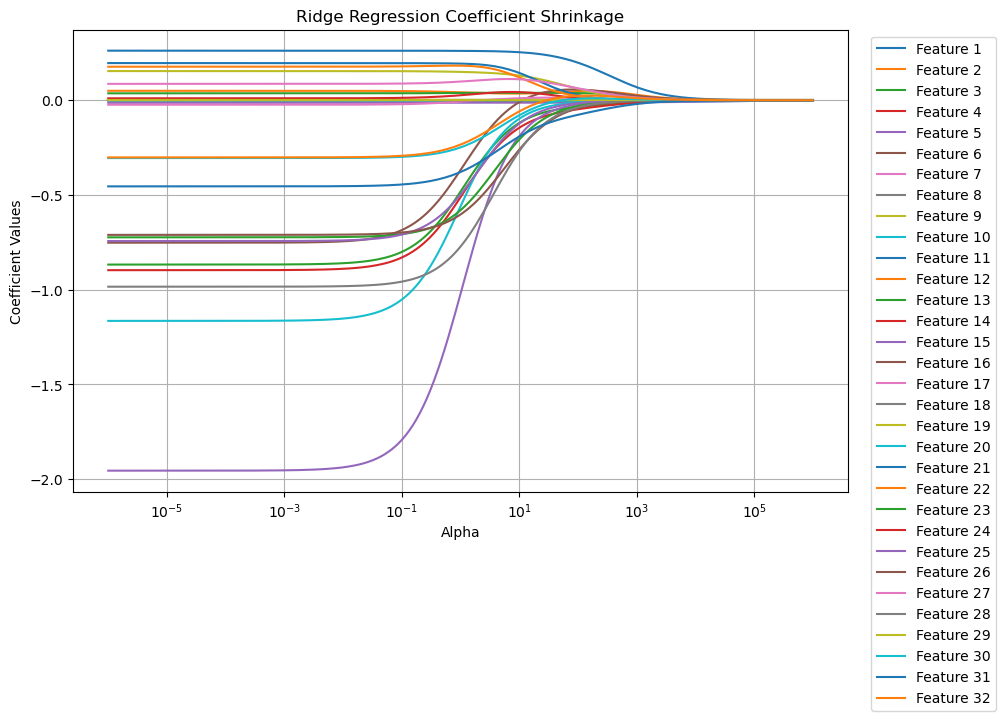

In [14]:
# Ridge shrinkage plot
alphas = np.logspace(-6, 6, 200)  # Logarithmic range for alpha
coefs = []

for alpha in alphas:
    ridge = RidgeClassifier(alpha=alpha)
    ridge.fit(X_train_resampled, y_train_resampled)
    coefs.append(ridge.coef_.flatten())  # Collect coefficients

coefs = np.array(coefs)

# Plotting the coefficients as a function of the regularization parameter
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f'Feature {i+1}')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Values')
plt.title('Ridge Regression Coefficient Shrinkage')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

In [15]:
# Train Bagging Classifier
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                             n_estimators=100, 
                             oob_score=True, 
                             random_state=100)
bagging.fit(X_train_resampled, y_train_resampled)
bagging_predictions = bagging.predict(X_test)
bagging_accuracy = metrics.accuracy_score(y_test, bagging_predictions)
print(f"Bagging Accuracy: {bagging_accuracy:.2f}")

Bagging Accuracy: 0.76


In [38]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=100)
rf.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 0.78


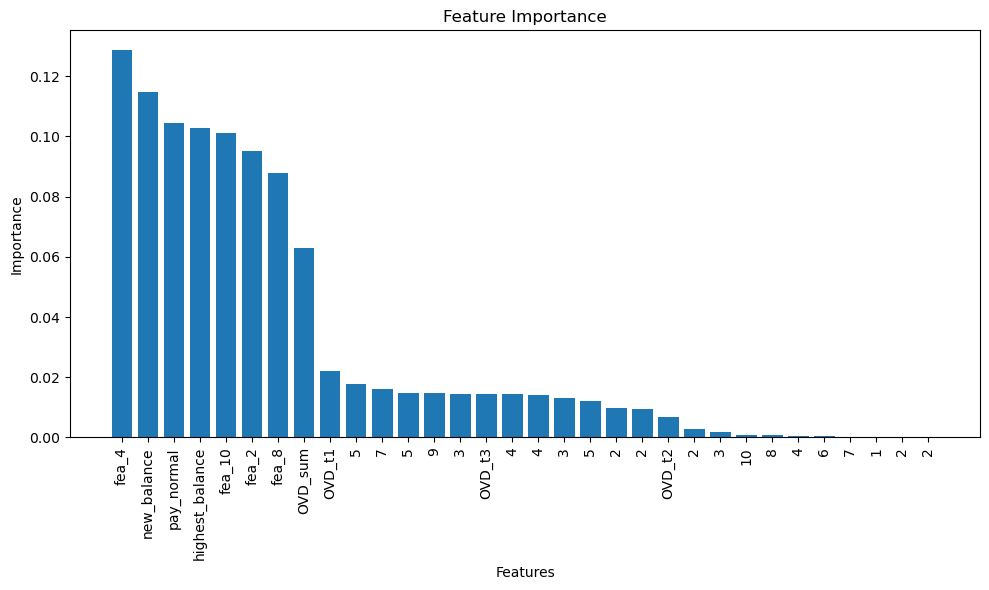

In [44]:
# Feature Importance
importances = rf.feature_importances_
feature_names = X_train_resampled.columns if isinstance(X_train_resampled, pd.DataFrame) else [f"Feature {i}" for i in range(X_train_resampled.shape[1])]
indices = np.argsort(importances)[::-1]  # Sort features by importance in descending order

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center", tick_label=np.array(feature_names)[indices])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [17]:
# Train AdaBoost Classifier
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), 
                               n_estimators=50, 
                               random_state=100)
adaboost.fit(X_train_resampled, y_train_resampled)
adaboost_predictions = adaboost.predict(X_test)
adaboost_accuracy = metrics.accuracy_score(y_test, adaboost_predictions)
print(f"AdaBoost Accuracy: {adaboost_accuracy:.2f}")

AdaBoost Accuracy: 0.70


C:\Users\piyum\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


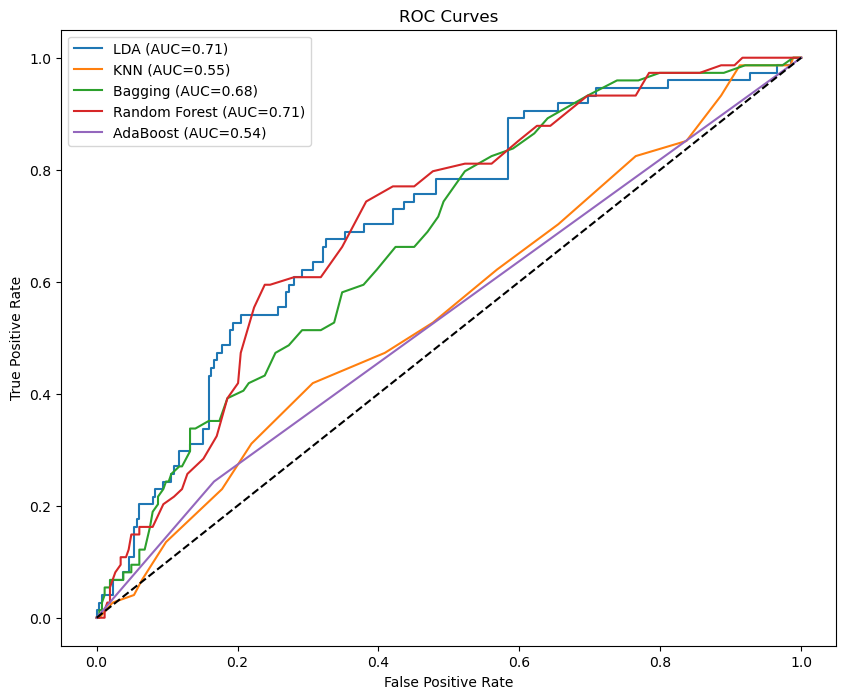

In [18]:
# ROC Curves
models = {
    'LDA': (lda_predictions, lda_model.predict_proba(X_test)[:, 1] if hasattr(lda_model, 'predict_proba') else None),
    'KNN': (knn_predictions, knn.predict_proba(X_test)[:, 1]),
    'Ridge': (ridge_predictions, None),
    'Bagging': (bagging_predictions, bagging.predict_proba(X_test)[:, 1]),
    'Random Forest': (rf_predictions, rf.predict_proba(X_test)[:, 1]),
    'AdaBoost': (adaboost_predictions, adaboost.predict_proba(X_test)[:, 1])
}

plt.figure(figsize=(10, 8))
for name, (pred, probs) in models.items():
    if probs is not None:
        fpr, tpr, _ = metrics.roc_curve(y_test, probs)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()